# Women in Data Science Datathon 2021

This is my [WiDS Datathon 2021](https://www.kaggle.com/c/widsdatathon2021/overview/description) solution write up.

A lot of feature engineering and feature selection ideas are based on the following two notebooks. 
* https://www.kaggle.com/siavrez/2020fatures 
* https://www.kaggle.com/kainsama/lgbm-wids2021-v0-1-1

# Problem Definition

In the Women in Data Science (WiDS) Datathon 2021, we will build a model to **determine whether a patient has been diagnosed with Diabetes Mellitus before** within the first 24 hours of being admitted to an Intensive Care Unit (ICU).
To improve a patient's outcome in an ICU knowledge about their medical conditions can improve clinical decisions.
However, often a patient's medical records are not immediately available due to transfer times. 
An additional challenge is when a patient is not able to provide such information due to their health condition, e.g. shock or unconsiousness.
Therefore, it is important to be able to diagnose whether a patient has chronical diseases based on data that can be gathered within the first 24 hours of being admitted to an ICU.
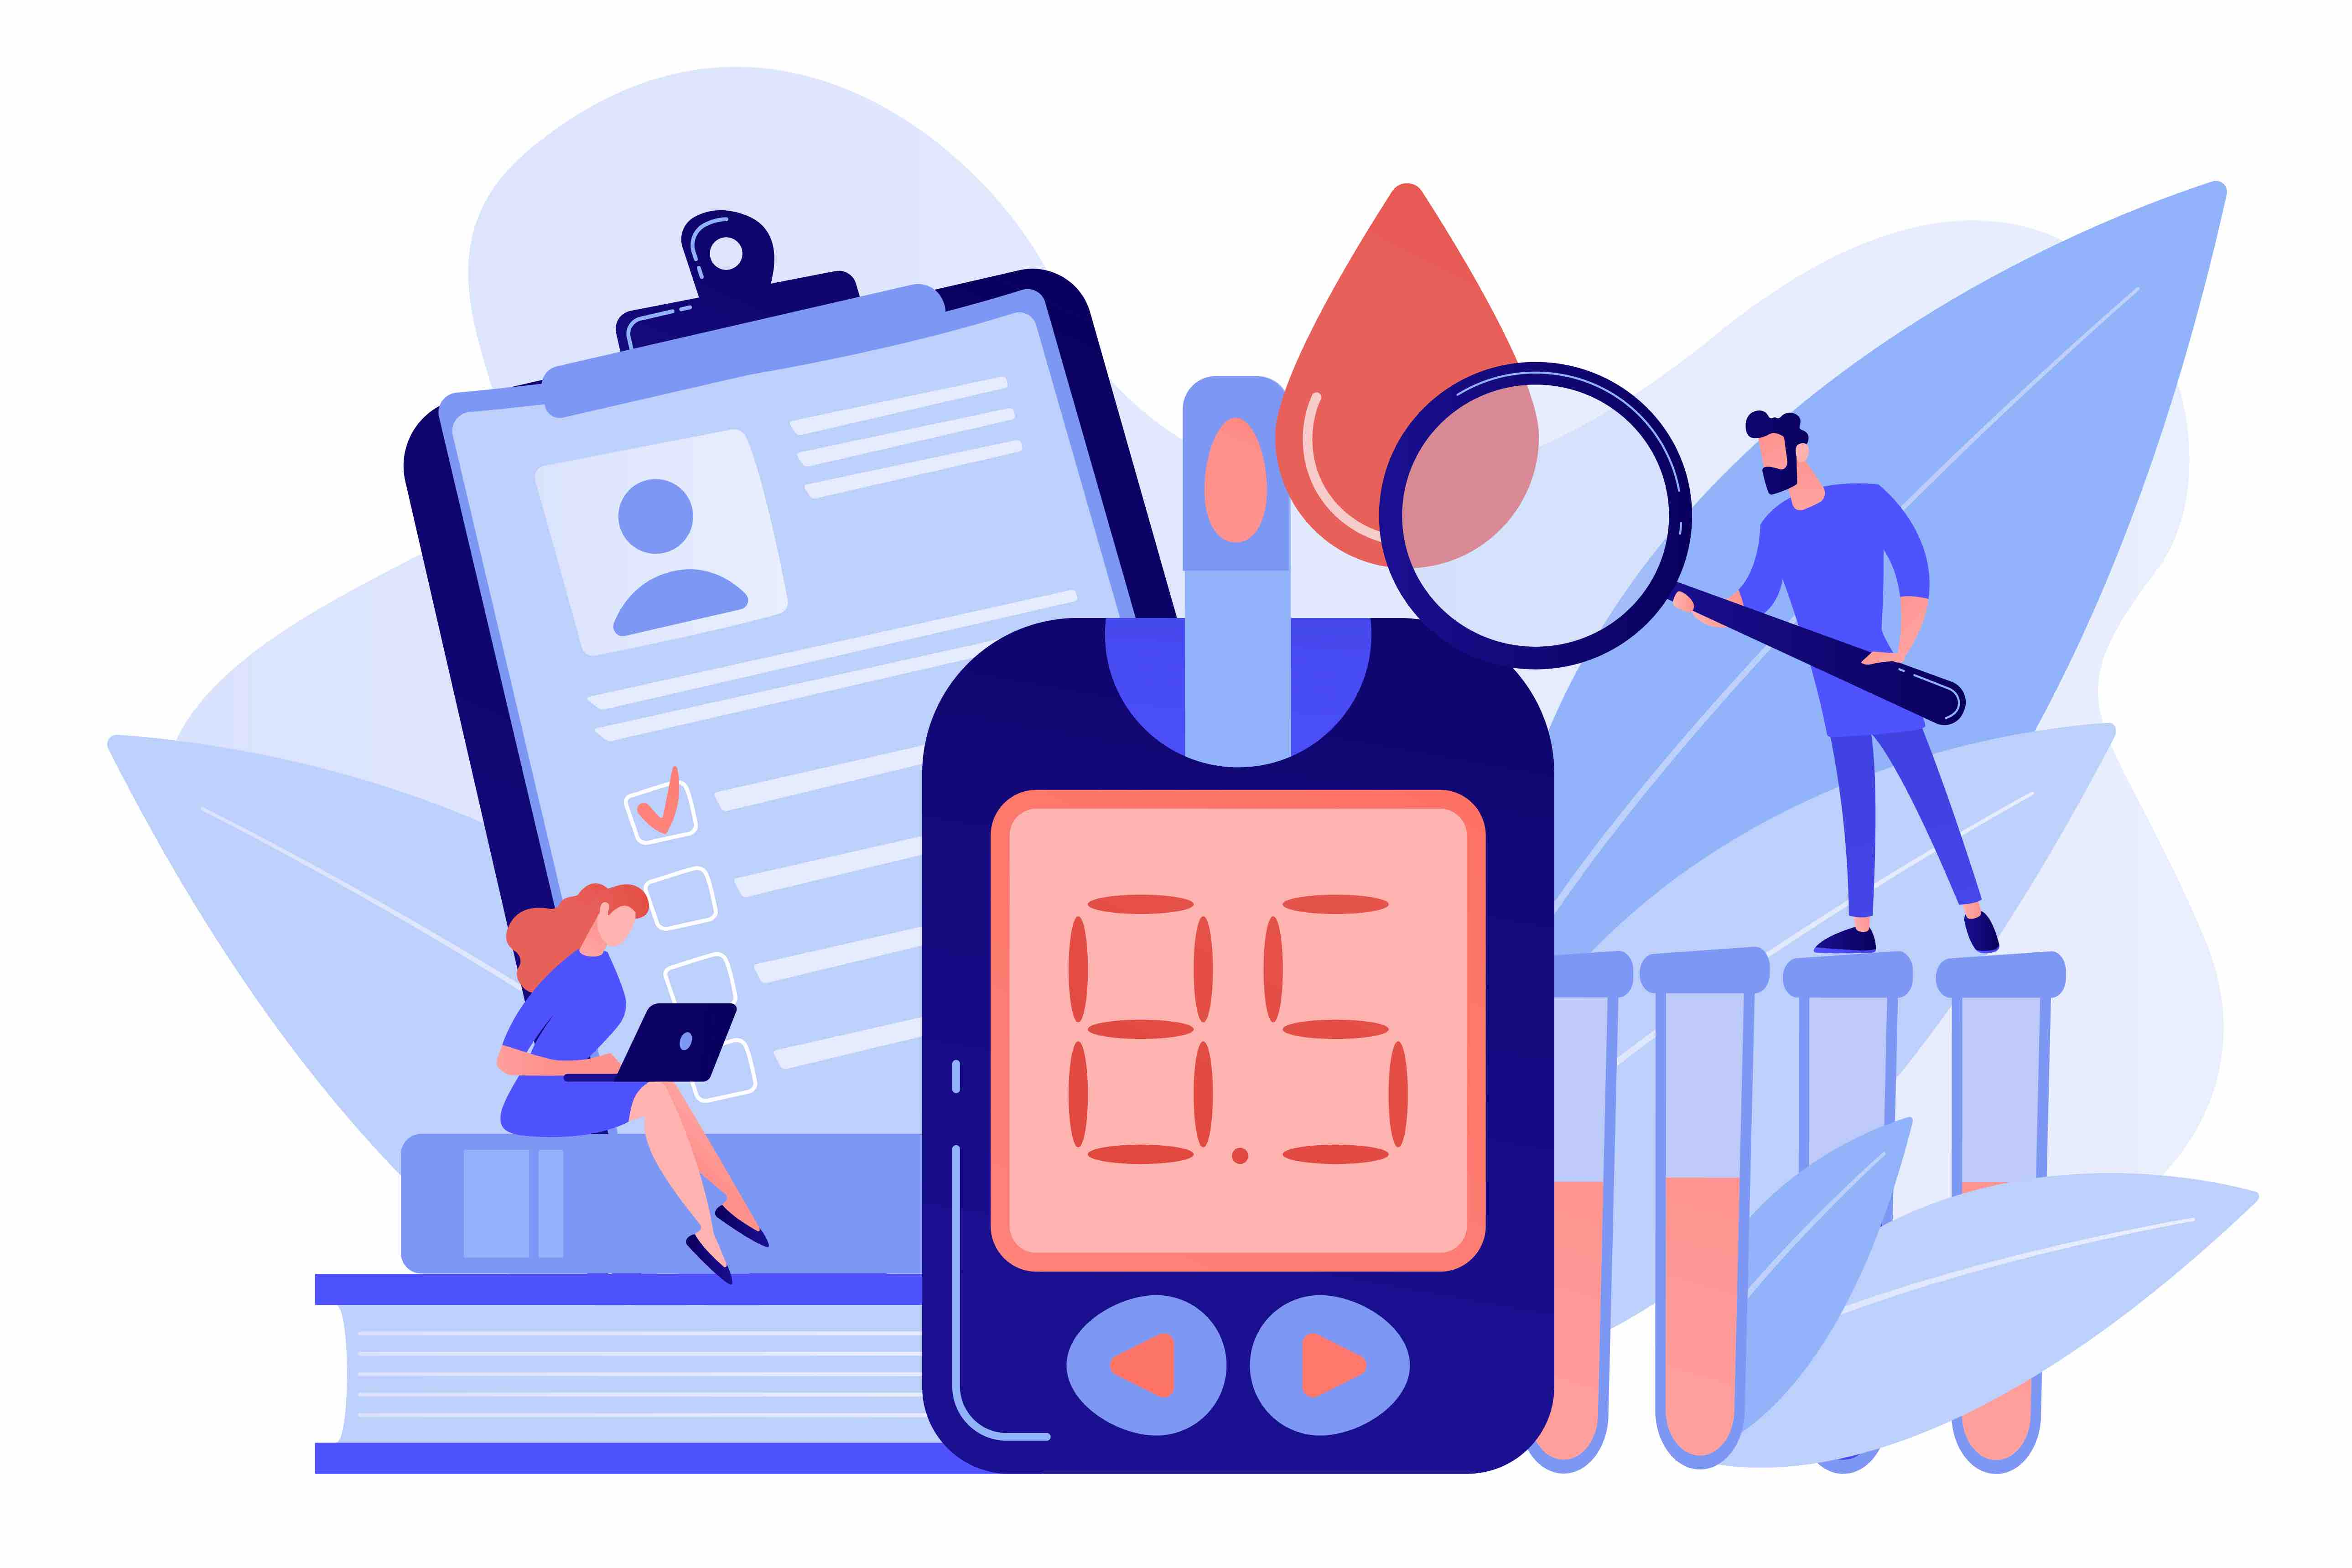
<a href="http://www.freepik.com">Designed by vectorjuice / Freepik</a>

## Diabetes Mellitus

According to the World Health Organization (WHO) Diabetes Mellitus, or commonly know as diabetes, is defined as follows:
> Diabetes is a chronic disease that occurs either when the pancreas **does not produce enough insulin or when the body cannot effectively use the insulin it produces**. Insulin is a hormone that regulates blood sugar. Hyperglycaemia, or **raised blood sugar**, is a common effect of uncontrolled diabetes and over time leads to serious damage to many of the body's systems, especially the nerves and blood vessels. - [WHO Diabetes Fact Sheet](https://www.who.int/news-room/fact-sheets/detail/diabetes)

There are two types of diabetes - **Type 1 diabetes and Type 2 diabetes**. Type 2 diabetes is more common than Type 1 diabetes and often results from excess body weight and physical inactivity while Type 1 diabetes is independent on body size. Additionally, there is **Gestational diabetes** in which a woman without diabetes develops high blood sugar levels during pregnancy. The latter usually resolves after birth while the other two types of diabetes have to be treated in the longterm.

Around **8.5 % of the adult population** is diagnosed with Diabetes [2] independent of the gender. 

**Indicators for Diabetes Mellitus**
Diabetes mellitus is characterized by high blood sugar levels over a prolonged period of time and is diagnosed by demonstrating any one of the following:
* Fasting plasma glucose level ≥ 7.0 mmol/L (126 mg/dL)
* Plasma glucose ≥ 11.1 mmol/L (200 mg/dL) two hours after a 75 gram oral glucose load as in a glucose tolerance test
* Symptoms of high blood sugar and casual plasma glucose ≥ 11.1 mmol/L (200 mg/dL)
* Glycated hemoglobin (HbA1C) ≥ 48 mmol/mol (≥ 6.5 DCCT %)

So, here are some ideas for the following analysis:
* Look at blood sugar levels but keep in mind that patients without diabetes can have high blood sugar levels as well
* Look at effects of diabetes on other organs, such as the kidney but keep in mind that patients without diabetes can have kidney disfunctions as well
* Race could be included since some races apparently tend to get diabetes at lower BMIs
* Most interesting categories of features are: demographic, vitals, labs, labs blood gas
* APACHE is an illness severity score. Also the APACHE score has suboptimal calibration which makes it hard to compare across different hospitals. Therefore, the APACHE covariates features are probably not as interesting for detecting diabetes. We will focus on them if we have some time left at the end.
* We need to consider whether we want to use less frequently measured variables


# Data Overview
The data is provided by MIT’s GOSSIS (Global Open Source Severity of Illness Score) initiative. It contains:
* 179 features from 6 feature categories: identifier, demographic, APACHE covariate, vitals, labs, labs blood gas, APACHE comorbidity
* 1 target `diabetes_mellitus`

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # visualization
import matplotlib.gridspec as gridspec

import seaborn as sns # visualization

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

import category_encoders as ce

from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

# Classifiers
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, f1_score, confusion_matrix

import time

SEED = 2021

# Load data
train_df = pd.read_csv("../input/widsdatathon2021/TrainingWiDS2021.csv", index_col=[0])
test_df = pd.read_csv("../input/widsdatathon2021/UnlabeledWiDS2021.csv", index_col=[0])
data_dict_df = pd.read_csv("../input/widsdatathon2021/DataDictionaryWiDS2021.csv")

# Rename similar columns
# Copied from https://www.kaggle.com/siavrez/2020fatures
train_df = train_df.rename(columns={'ph_apache':'arterial_ph_apache'})
test_df = test_df.rename(columns={'ph_apache':'arterial_ph_apache'})

# Shuffle training data
train_df = train_df.sample(frac=1, random_state = SEED).reset_index(drop=True)

train_df.head().style.set_caption('Sample of shuffled training data')

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,arterial_ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,220404,194,59.000000,18.404908,0,Caucasian,F,163.000000,Emergency Department,Accident & Emergency,601,admit,MICU,0.150000,0,48.900000,nan,108.000000,203.010000,0,0,nan,18.000000,0.520000,nan,3.000000,5.000000,0.000000,1.000000,144.000000,102.000000,37.800000,0,131.000000,nan,nan,nan,nan,11.000000,138.000000,36.800000,nan,1,6.900000,nan,nan,87.000000,51.000000,87.000000,51.000000,94.000000,51.000000,nan,nan,111.000000,65.000000,111.000000,65.000000,23.000000,13.000000,100.000000,95.000000,nan,nan,187.000000,90.000000,187.000000,90.000000,37.100000,36.800000,nan,nan,87.000000,81.000000,87.000000,81.000000,94.000000,87.000000,nan,nan,111.000000,107.000000,111.000000,107.000000,23.000000,19.000000,100.000000,99.000000,nan,nan,187.000000,154.000000,187.000000,154.000000,nan,nan,nan,nan,nan,nan,18.000000,18.000000,8.700000,8.700000,0.520000,0.520000,144.000000,144.000000,26.000000,26.000000,12.800000,12.800000,37.800000,37.800000,nan,nan,nan,nan,221.000000,221.000000,3.500000,3.500000,138.000000,138.000000,6.900000,6.900000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n

The class imbalance of the target variable is a challenge in any machine learning problem. Therefore, it is also a challenge in the application for diabetes diagnosis [3]. 
According to WHO in 2014 8.5 % of adults were diagnoses with diabetes [2]. **In the provided training data 22% of patients are diagnosed with diabetes**.

0    78.371505
1    21.628495
Name: diabetes_mellitus, dtype: float64

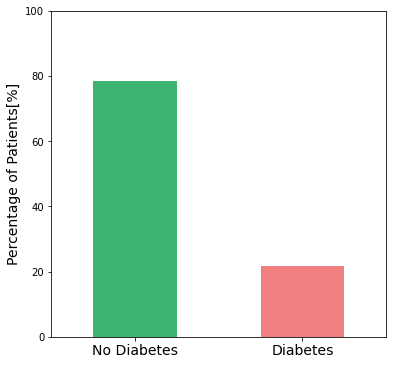

In [2]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
(train_df.diabetes_mellitus.value_counts(normalize=True)*100).plot(kind='bar', color=['mediumseagreen', 'lightcoral'])
display(train_df.diabetes_mellitus.value_counts(normalize=True)*100)
ax.set_ylim([0, 100])
ax.set_ylabel('Percentage of Patients[%]', fontsize=14)
ax.set_xticklabels(['No Diabetes', 'Diabetes'], fontsize=14, rotation=0)
plt.show()

# Data Cleaning

## Identifiers
There are 204 unique `hospital_id` in the training data and 190 in the test data. The `hospital_id` in the training and the testing data are disjunct - meaning that none of the `hospital_id`  in the training data are in the testing data and vice versa. The `hospital_id` in the training data range from 1 to 204 while they range from 10001 to 10199 in the testing data. We could check whether `hospital_id` 1 would correspond to `hospital_id` 10001 in testing data. However, since intuitively the `hospital_id` is not a relevant feature whether a patient has been diagnosed with diabetes before, we will not analyse this further. Therefore, **`hospital_id` should probably be not included in the final features.**
However, we will **use `hospital_id` as a group for GroupKFold validation in the training step.**

Furthermore, `encounter_id` is used to identify a patient. This identifier will also not be included as a feature but is relevant for further steps.

Finally, `icu_id` has shared values across the raining and testing datasets and therefore, it will not be dropped.

## Readmission Status

Furthermore, we will drop the column `readmission_status` because it only has one unique value of 0.

In [3]:
print(train_df['readmission_status'].unique())
print(test_df['readmission_status'].unique())

# Drop readmission_status column
train_df.drop("readmission_status", axis=1, inplace=True)
test_df.drop("readmission_status", axis=1, inplace=True)

[0]
[0]


## Drop Duplicate Columns
`paco2_apache` and `paco2_for_ph_apache` are identical and one of them will be dropped. 
`d1_inr_min/max` and `h1_inr_min/max` are also identical. However, they will not be dropped at this stage to use them for further feature engineering in the followng steps.

In [4]:
for i, col_1 in enumerate(train_df.columns):
    for col_2 in train_df.columns[(i+1):]:
        if train_df[col_1].equals(train_df[col_2]):
            print(f"{col_1} and {col_2} are identical.")
            
identical_cols = ["paco2_for_ph_apache"]            
train_df.drop(identical_cols, axis=1, inplace=True)
test_df.drop(identical_cols, axis=1, inplace=True)

paco2_apache and paco2_for_ph_apache are identical.
d1_inr_max and h1_inr_max are identical.
d1_inr_min and h1_inr_min are identical.


We will drop the `invasive`/`noninvasive` columns due to their high rate of missing values and their redundancy with the  `diasbp`, `sysbp`, and `mpb` columns. 

In [5]:
drop_columns = train_df.columns[train_df.columns.str.contains('invasive')]

train_df.drop(drop_columns, axis=1, inplace=True)
test_df.drop(drop_columns, axis=1, inplace=True)

## Implausible Age
We are working with data from **young adults and adults aging 16 and older**. However, in the training data, there are 30 data points with `age = 0`. For the initial analysis purposes, we will drop these data points because they have on average have twice as many NaN values then the average data point. Usually, dropping data is not recommended. However, these data points only account for 0.02% of data loss in addition to the earlier argument.

In [6]:
print(f"There are {len(train_df[train_df.age<16])} data points in the training data set with age = 0.")
print(f"There are {len(test_df[test_df.age<16])} data points in the training data set with age = 0.")

display(train_df[train_df.age<16])

# Delete implausible age (test data has no implausible age)
train_df.loc[train_df.age == 0, 'age'] = np.nan
test_df.loc[test_df.age == 0, 'age'] = np.nan

There are 30 data points in the training data set with age = 0.
There are 0 data points in the training data set with age = 0.


,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
1000,163444,199,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
2737,159417,167,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
3717,225543,167,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
6643,147946,7,0.0,16.110362,0,NaN,NaN,149.9,NaN,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
8810,273814,85,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
22713,147789,167,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
31112,255197,177,0.0,21.342855,0,NaN,F,193.0,NaN,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
32536,244601,167,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
34709,234525,167,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
36691,168821,16,0.0,30.511019,0,NaN,NaN,172.7,NaN,Floor,...,NaN,NaN,0,0,0,0,0,0,0,0


## Unknown Gender, Weight & Height
We will drop 18 rows of training data where gender, weight and height of the patient are unknown.

In [7]:
display(train_df[train_df.gender.isna() & train_df.height.isna() & train_df.weight.isna()])

display(test_df[test_df.gender.isna() & test_df.height.isna() & test_df.weight.isna()])
print(len(train_df))
train_df = train_df[~(train_df.gender.isna() & train_df.height.isna() & train_df.weight.isna())].reset_index(drop=True)
print(len(train_df))

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
1000,163444,199,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
2737,159417,167,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
3717,225543,167,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
5104,183445,14,NaN,NaN,0,Other/Unknown,NaN,NaN,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
8810,273814,85,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
19893,153838,177,81.0,NaN,0,NaN,NaN,NaN,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
22713,147789,167,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
32536,244601,167,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
34709,234525,167,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
41551,209548,169,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis


130157
130139


# Handling Missing Values

## Gender
Based on the age, height, and weight of a patient, we will fill the missing values for gender by prediction with logistic regression.

In [8]:
train_df["gender"] = train_df["gender"].fillna("Unknown").replace({'M':0, 'F':1, 'Unknown':-1})
train_df["ethnicity"] = train_df["ethnicity"].fillna("Other/Unknown")

test_df["gender"] = test_df["gender"].fillna("Unknown").replace({'M':0, 'F':1, 'Unknown':-1})
test_df["ethnicity"] = test_df["ethnicity"].fillna("Other/Unknown")

# Fill Unknown gender by prediction
train_df_mod = train_df[['age', 'ethnicity', 'height', 'weight', 'gender']].copy()
test_df_mod = test_df[['age', 'ethnicity', 'height', 'weight', 'gender']].copy()

mean_age = train_df_mod.age.mean()
mean_height = train_df_mod.height.mean()
mean_weight = train_df_mod.weight.mean()

train_df_mod['age'] = train_df_mod['age'].fillna(mean_age)
train_df_mod['height'] = train_df_mod['height'].fillna(mean_height)
train_df_mod['weight'] = train_df_mod['weight'].fillna(mean_weight)

test_df_mod['age'] = test_df_mod['age'].fillna(mean_age)
test_df_mod['height'] = test_df_mod['height'].fillna(mean_height)
test_df_mod['weight'] = test_df_mod['weight'].fillna(mean_weight)


features = ['age', 'height', 'weight']
target = ['gender']

for ethn in train_df.ethnicity.unique():
    if ethn != 'Other/Unknown':
        X = train_df_mod[(train_df_mod.ethnicity == ethn) & (train_df_mod.gender != -1)][features]
        y = train_df_mod[(train_df_mod.ethnicity == ethn)& (train_df_mod.gender != -1)][target]
        X_test_train = train_df_mod[(train_df_mod.ethnicity == ethn) & (train_df_mod.gender == -1)][features]
        X_test_test = test_df_mod[(test_df_mod.ethnicity == ethn) & (test_df_mod.gender == -1)][features]

    else:
        X = train_df_mod[(train_df_mod.gender != -1)][features]
        y = train_df_mod[(train_df_mod.gender != -1)][target]
        X_test_train = train_df_mod[(train_df_mod.gender == -1)][features]
        X_test_test = test_df_mod[(test_df_mod.gender == -1)][features]
    

    model = LogisticRegression(random_state=SEED).fit(X, y)
    if len(X_test_train) > 0:
        pred = model.predict(X_test_train)
        for i, idx in enumerate(X_test_train.index):
            train_df.at[idx, 'gender'] = pred[i]
        
    if len(X_test_test) > 0:
        pred = model.predict(X_test_test)
        for i, idx in enumerate(X_test_test.index):
            test_df.at[idx, 'gender'] = pred[i]
    

## Weight and Height
For the weight and height, we will create lookup tables with the mean values grouped by gender, ethnicity, and age. The missing values for weight and height will be filled from the lookup tables.

In [9]:
# Fill missing height and weight from lookup table
train_df['age_bins'] = pd.cut(train_df.age, [0, 20, 40, 60, 80, 120], labels=False)
test_df['age_bins'] = pd.cut(test_df.age, [0, 20, 40, 60, 80, 120], labels=False)
lookup_df = train_df[(train_df.ethnicity != 'Other/Unknown')].groupby(['gender', 'ethnicity', 'age_bins'])[["height", "weight"]].mean()
lookup_df.columns = ['height_lookup', 'weight_lookup']
display(lookup_df.style.set_caption("Lookup Table for Weight and Height"))
lookup_df = lookup_df.reset_index(drop=False)

train_df = train_df.merge(lookup_df, on=['gender', 'ethnicity', 'age_bins'], how='left')
test_df = test_df.merge(lookup_df, on=['gender', 'ethnicity', 'age_bins'], how='left')

train_df["height"] = np.where(train_df["height"].isna(), train_df["height_lookup"], train_df["height"])
train_df["weight"] = np.where(train_df["weight"].isna(), train_df["weight_lookup"], train_df["weight"])

test_df["height"] = np.where(test_df["height"].isna(), test_df["height_lookup"], test_df["height"])
test_df["weight"] = np.where(test_df["weight"].isna(), test_df["weight_lookup"], test_df["weight"])

train_df.drop(['height_lookup', 'weight_lookup', 'age_bins'], axis=1, inplace=True)
test_df.drop(['height_lookup', 'weight_lookup', 'age_bins'], axis=1, inplace=True)

# Fill on gender and ethnicity only for unknown age
lookup_df = train_df[(train_df.ethnicity != 'Other/Unknown')].groupby(['gender', 'ethnicity'])[["height", "weight"]].mean()
lookup_df.columns = ['height_lookup', 'weight_lookup']
#display(lookup_df)
lookup_df = lookup_df.reset_index(drop=False)

train_df = train_df.merge(lookup_df, on=['gender', 'ethnicity'], how='left')
test_df = test_df.merge(lookup_df, on=['gender', 'ethnicity'], how='left')

train_df["height"] = np.where(train_df["height"].isna(), train_df["height_lookup"], train_df["height"])
train_df["weight"] = np.where(train_df["weight"].isna(), train_df["weight_lookup"], train_df["weight"])

test_df["height"] = np.where(test_df["height"].isna(), test_df["height_lookup"], test_df["height"])
test_df["weight"] = np.where(test_df["weight"].isna(), test_df["weight_lookup"], test_df["weight"])

train_df.drop(['height_lookup', 'weight_lookup'], axis=1, inplace=True)
test_df.drop(['height_lookup', 'weight_lookup'], axis=1, inplace=True)


# Fill on gender only for unknown ethnicity
lookup_df = train_df.groupby(['gender'])[["height", "weight"]].mean()
lookup_df.columns = ['height_lookup', 'weight_lookup']
#display(lookup_df)
lookup_df = lookup_df.reset_index(drop=False)

train_df = train_df.merge(lookup_df, on=['gender'], how='left')
test_df = test_df.merge(lookup_df, on=['gender'], how='left')

train_df["height"] = np.where(train_df["height"].isna(), train_df["height_lookup"], train_df["height"])
train_df["weight"] = np.where(train_df["weight"].isna(), train_df["weight_lookup"], train_df["weight"])

test_df["height"] = np.where(test_df["height"].isna(), test_df["height_lookup"], test_df["height"])
test_df["weight"] = np.where(test_df["weight"].isna(), test_df["weight_lookup"], test_df["weight"])

train_df.drop(['height_lookup', 'weight_lookup'], axis=1, inplace=True)
test_df.drop(['height_lookup', 'weight_lookup'], axis=1, inplace=True)

## Body Mass Index (BMI)
The Body Mass Index (BMI) is a metric to indicate how a persons weight is in relation to their height and is calculated as follows: $\text{BMI} = \dfrac{\text{weight}}{\text{height}^2}$

Since we have the patients' height and weight, we can do a quick sanity check of the BMI data. The sanity check showed that there are deviations between the calculated BMI and the given BMI values due to the limited values of weight and height. The weight and height can be reconstructed, however, we will skip this step here.

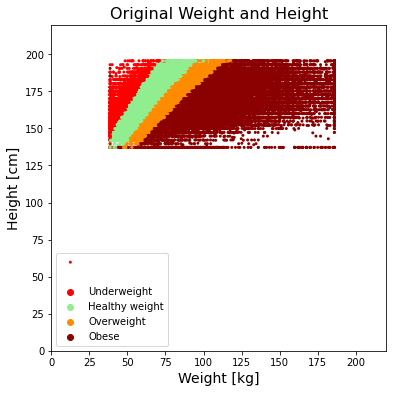

In [10]:
def get_bmi_category(bmi):
    
    if bmi != bmi: # NaN
        return np.nan
    elif bmi < 18.5: # Underweight
        return -1
    elif bmi < 25: # Healthy weight
        return 0
    elif bmi < 30: # Overweight
        return 1
    else: # Obese
        return 2

train_df["bmi_cat"] = train_df["bmi"].apply(get_bmi_category)
test_df["bmi_cat"] = test_df["bmi"].apply(get_bmi_category)

train_df["bmi_calc"] = np.round(train_df.weight / ((train_df.height/100)**2), 8)
test_df["bmi_calc"] = np.round(test_df.weight / ((test_df.height/100)**2), 8)

train_df["bmi"] = np.where(train_df["bmi"].isna(), train_df["bmi_calc"], train_df["bmi"])
test_df["bmi"] = np.where(test_df["bmi"].isna(), test_df["bmi_calc"], test_df["bmi"])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=train_df.weight, y=train_df.height, hue=train_df.bmi_cat, palette=['red', 'lightgreen', 'darkorange', 'darkred'], linewidth=0, marker='.', ax=ax)
ax.set_title('Original Weight and Height', fontsize=16)
ax.set_xlabel('Weight [kg]', fontsize = 14)
ax.set_ylabel('Height [cm]', fontsize = 14)

ax.set_xlim([0, 220])
ax.set_ylim([0, 220])
ax.legend(['', '', 'Underweight', 'Healthy weight', 'Overweight', 'Obese'])

plt.show()
train_df.drop(['bmi_calc', 'bmi_cat'], axis=1, inplace=True)
test_df.drop(['bmi_calc', 'bmi_cat'], axis=1, inplace=True)


## Categorical Columns
We will fill the missing values for the `hospital_admit_source` and `icu_admit_source` already have columns indicating missing values, such as 'Other' or 'Unknown. We will be using these.

For `icu_stay_type` and `icu_type`, we will be filling the missing values with the column most common value.

In [11]:
train_df["hospital_admit_source"] = train_df["hospital_admit_source"].fillna("Other")
train_df["icu_admit_source"] = train_df["icu_admit_source"].fillna("Other ICU")
train_df["icu_stay_type"] = train_df["icu_stay_type"].fillna("admit")
train_df["icu_type"] = train_df["icu_type"].fillna("Med-Surg ICU")

test_df["hospital_admit_source"] = test_df["hospital_admit_source"].fillna("Other")
test_df["icu_admit_source"] = test_df["icu_admit_source"].fillna("Other ICU")
test_df["icu_stay_type"] = test_df["icu_stay_type"].fillna("admit")
test_df["icu_type"] = test_df["icu_type"].fillna("Med-Surg ICU")

icu_dict = {'Other ICU' : 'ICU',
            'ICU to SDU' : 'SDU', 
            'Step-Down Unit (SDU)' : 'SDU',
            'Other Hospital':'Other',
            'Observation': 'Recovery Room',
            'Acute Care/Floor': 'Floor'}

train_df['hospital_admit_source'] = train_df['hospital_admit_source'].replace(icu_dict)
test_df['hospital_admit_source'] = test_df['hospital_admit_source'].replace(icu_dict)

## Admit Source
`hospital_admit_source` and `icu_admit_source` will be condensed to one feature. The following heatmap shows how both are related to each other. We will fill missing values for `icu_admit_source` based on the information of `hospital_admit_source` if available.

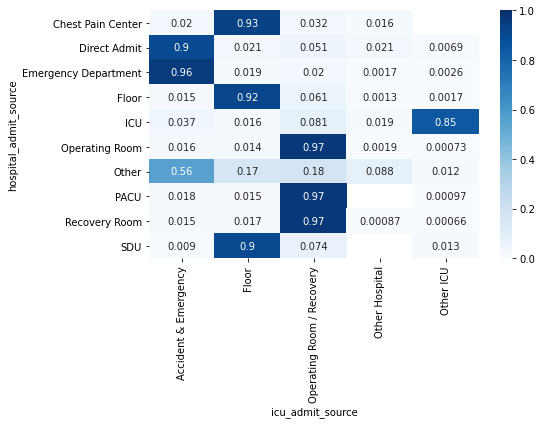

In [12]:
admit_source_df = (train_df.groupby('hospital_admit_source').icu_admit_source.value_counts(normalize=True)).to_frame()
admit_source_df.columns = ['percentage']
admit_source_df.reset_index(drop=False, inplace=True)
admit_source_df = admit_source_df.pivot(index='hospital_admit_source', columns='icu_admit_source')['percentage']

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(admit_source_df, cmap='Blues', vmin=0, vmax=1, annot=True)
plt.tight_layout()
plt.show()

icu_hospital_admit_source_dict = {
    'Floor' : 'Floor', 
    'Emergency Department' : 'Accident & Emergency', 
    'Operating Room' : 'Operating Room / Recovery', 
    'Direct Admit' : 'Accident & Emergency' , 
    'ICU' :  'Other ICU', 
    'SDU' : 'Floor', 
    'Recovery Room' : 'Operating Room / Recovery', 
    'Chest Pain Center' : 'Floor', 
    'PACU' : 'Operating Room / Recovery'
}

def get_icu_admit_source_from_hospital(df):
    for key in icu_hospital_admit_source_dict:
        if df.hospital_admit_source == key:
            df.icu_admit_source = icu_hospital_admit_source_dict[key]
    return df.icu_admit_source

train_df['icu_admit_source'] = train_df.apply(lambda x: get_icu_admit_source_from_hospital(x) if x.icu_admit_source == 'Other Hospital' else x.icu_admit_source, axis=1)
train_df['icu_admit_source'] = train_df.apply(lambda x: get_icu_admit_source_from_hospital(x) if x.icu_admit_source == 'Other ICU' else x.icu_admit_source, axis=1)

test_df['icu_admit_source'] = test_df.apply(lambda x: get_icu_admit_source_from_hospital(x) if x.icu_admit_source == 'Other Hospital' else x.icu_admit_source, axis=1)
test_df['icu_admit_source'] = test_df.apply(lambda x: get_icu_admit_source_from_hospital(x) if x.icu_admit_source == 'Other ICU' else x.icu_admit_source, axis=1)

# Drop first column because it is identical to index
train_df.drop(["hospital_admit_source", "icu_stay_type",],  axis = 1, inplace = True)
test_df.drop(["hospital_admit_source", "icu_stay_type", ], axis = 1, inplace = True)


# Electrive Surgery
train_df["icu_admit_source"] = np.where(((train_df["elective_surgery"] == 1) & ((train_df["icu_admit_source"] == 'Other ICU') | (train_df["icu_admit_source"] == 'Other Hospital'))), 
                                   "Operating Room / Recovery", 
                                   train_df["icu_admit_source"])
                                        
test_df["icu_admit_source"] = np.where(((test_df["elective_surgery"] == 1) & ((test_df["icu_admit_source"] == 'Other ICU') | (test_df["icu_admit_source"] == 'Other Hospital'))), 
                                   "Operating Room / Recovery", 
                                   test_df["icu_admit_source"])

train_df.drop("elective_surgery", axis = 1, inplace = True)
test_df.drop("elective_surgery", axis = 1, inplace = True)

# Feature Engineering

In [13]:
# Edited from https://www.kaggle.com/jayjay75/3rd-place-nn-wids2020?scriptVersionId=29209297

# comorbidity_score
train_df['comorbidity_score'] = train_df['aids'] * 23 + train_df['cirrhosis'] * 4 + train_df['hepatic_failure'] * 16 + train_df['immunosuppression'] * 10 + train_df['leukemia'] * 10 + train_df['lymphoma'] * 13 + train_df['solid_tumor_with_metastasis'] * 11
train_df['comorbidity_score'] = train_df['comorbidity_score'].fillna(0)

test_df['comorbidity_score'] = test_df['aids'] * 23 + test_df['cirrhosis'] * 4 + test_df['hepatic_failure'] * 16 + test_df['immunosuppression'] * 10 + test_df['leukemia'] * 10 + test_df['lymphoma'] * 13 + test_df['solid_tumor_with_metastasis'] * 11
test_df['comorbidity_score'] = test_df['comorbidity_score'].fillna(0)

train_df["total_chronic"] = train_df[["aids", "cirrhosis", 'hepatic_failure']].sum(axis=1)
test_df["total_chronic"] = test_df[["aids","cirrhosis", 'hepatic_failure']].sum(axis=1)

# GCS
train_df['gcs_eyes_apache'] = train_df['gcs_eyes_apache'].fillna(4)
train_df['gcs_verbal_apache'] = train_df['gcs_verbal_apache'].fillna(5)
train_df['gcs_motor_apache'] = train_df['gcs_motor_apache'].fillna(6)

train_df['gcs_score'] = train_df[['gcs_eyes_apache', 'gcs_motor_apache','gcs_verbal_apache']].sum(axis=1)
train_df['gcs_score_type'] = train_df.gcs_score.apply(lambda x: 2.5 * (round(int(x)/2.5))).divide(2.5)

test_df['gcs_eyes_apache'] = test_df['gcs_eyes_apache'].fillna(4)
test_df['gcs_verbal_apache'] = test_df['gcs_verbal_apache'].fillna(5)
test_df['gcs_motor_apache'] = test_df['gcs_motor_apache'].fillna(6)

test_df['gcs_score'] = test_df[['gcs_eyes_apache', 'gcs_motor_apache','gcs_verbal_apache']].sum(axis=1)
test_df['gcs_score_type'] = test_df.gcs_score.apply(lambda x: 2.5 * (round(int(x)/2.5))).divide(2.5)

gcs_cols = ['gcs_eyes_apache', 'gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache']

train_df.drop(gcs_cols, axis=1, inplace=True)
test_df.drop(gcs_cols, axis=1, inplace=True)


## APACHE

https://www.kaggle.com/danofer/apache-iiij-icu-diagnosis-codes?select=icu-apache-codes-ANZICS.csv

APACHE II diagnosis and APACHE IIIj diagnosis contain redundant information. APACHE IIIj diagnosis contains more fine-grained information than APACHE II diagnosis. APACHE IIIj diagnosis will be dropped later.


In [14]:
train_df['apache_2_diagnosis'] = (train_df.apache_2_diagnosis).fillna(0).astype(int)
train_df['apache_2_diagnosis_type'] = train_df.apache_2_diagnosis.round(-1).fillna(0).astype(int)
train_df['apache_3j_diagnosis'] = (train_df.apache_3j_diagnosis).fillna(0).astype(int)
train_df['apache_3j_diagnosis_type'] = train_df.apache_3j_diagnosis.round(-2).fillna(0).astype(int)

test_df['apache_2_diagnosis'] = (test_df.apache_2_diagnosis).fillna(0).astype(int)
test_df['apache_2_diagnosis_type'] = test_df.apache_2_diagnosis.round(-1).fillna(0).astype(int)
test_df['apache_3j_diagnosis'] = (test_df.apache_3j_diagnosis).fillna(0).astype(int)
test_df['apache_3j_diagnosis_type'] = test_df.apache_3j_diagnosis.round(-2).fillna(0).astype(int)


## Diabetic Ketoacidosis
Since APACHE 3J Diagnosis 702 corresponds to diabetic ketoacidosis, we will create this feature. However, not all patients with diabetic ketoacidosis are marked with diabetes mellitus as discussed [in this discussion](https://www.kaggle.com/c/widsdatathon2021/discussion/220093).

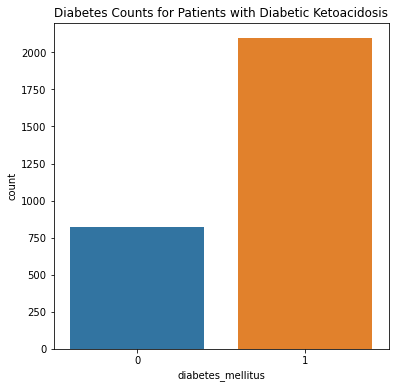

In [15]:
train_df['APACHE_diabetic_ketoacidosis'] = train_df.apache_3j_diagnosis.apply(lambda x: 1 if x == 702 else 0)
test_df['APACHE_diabetic_ketoacidosis'] = test_df.apache_3j_diagnosis.apply(lambda x: 1 if x == 702 else 0)

diabetic_ketoacidosis_df = train_df[train_df.APACHE_diabetic_ketoacidosis == 1]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.countplot(diabetic_ketoacidosis_df.diabetes_mellitus, ax=ax)
ax.set_title('Diabetes Counts for Patients with Diabetic Ketoacidosis')
plt.show()

## Pregnancy Probability
Since diabetes can occur during pregnancy, we will create a feature that can help the model evaluate whether a patient might be pregnant of not
https://www.cdc.gov/nchs/products/databriefs/db136.htm

In [16]:
def get_pregnancy_probability(df):
    if df.gender == 0: # Male
        return 0
    else: # Female
        if df.apache_3j_diagnosis == 1802: # Pregnancy-related disorder 
            return 1
        else:
            if df.age < 20:
                return 0.07
            elif df.age < 25:
                return 0.15
            elif df.age < 30:
                return 0.16
            elif df.age < 35:
                return 0.14
            elif df.age < 40:
                return 0.08
            elif df.age < 45:
                return 0.02
            else:
                return 0
            
train_df['pregnancy_probability'] = train_df.apply(lambda x: get_pregnancy_probability(x), axis=1)
test_df['pregnancy_probability'] = test_df.apply(lambda x: get_pregnancy_probability(x), axis=1)

# Visualization
train_df['age_bins'] = pd.cut(train_df.age, [0, 20, 30, 35, 40, 45, 120], labels=False)
temp = train_df.groupby(['gender', 'age_bins']).pregnancy_probability.mean().to_frame().reset_index(drop=False)
temp = temp.pivot(index='gender', columns='age_bins').pregnancy_probability
temp.columns = ['<20', '20-30', '30-35', '35-40', '40-45', '>45']
temp = temp.T
temp.columns = ['Male', 'Female']
display(temp.style.set_caption('Mean Pregnancy Probability According to Age and Gender').background_gradient(cmap='Reds'))
train_df.drop('age_bins', axis=1, inplace=True)

,Male,Female
<20,0.000000,0.105802
20-30,0.000000,0.180434
30-35,0.000000,0.154916
35-40,0.000000,0.090375
40-45,0.000000,0.019958
>45,0.000000,0.000000


## Categorical Features: One Hot Encoding
One Hot Encode categorical columns.

In [17]:
# Categorical Feature Encoding
object_cols = ['ethnicity', 'icu_admit_source', 'icu_type' ]
display(train_df[object_cols].head().style.set_caption("Object columns before One Hot Encoding"))

# Apply OH Encoding
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
OH_cols_train = pd.DataFrame(ohe.fit_transform(train_df[object_cols]))
OH_cols_train.index = train_df.index

OH_cols_test = pd.DataFrame(ohe.transform(test_df[object_cols]))
OH_cols_test.index = test_df.index

display(OH_cols_train.head().style.set_caption("Object columns after One Hot Encoding"))

# Drop original categorical columns and replace with OH encoded columns
#train_df.drop(object_cols, axis=1, inplace=True)
train_df = pd.concat([train_df, OH_cols_train], axis=1)

#test_df.drop(object_cols, axis=1, inplace=True)
test_df = pd.concat([test_df, OH_cols_test], axis=1)

,ethnicity,icu_admit_source,icu_type
0,Caucasian,Accident & Emergency,MICU
1,Caucasian,Operating Room / Recovery,Med-Surg ICU
2,Caucasian,Accident & Emergency,Med-Surg ICU
3,Caucasian,Accident & Emergency,CCU-CTICU
4,Caucasian,Accident & Emergency,Med-Surg ICU


,ethnicity_Caucasian,ethnicity_Asian,ethnicity_African American,ethnicity_Native American,ethnicity_Other/Unknown,ethnicity_Hispanic,icu_admit_source_Accident & Emergency,icu_admit_source_Operating Room / Recovery,icu_admit_source_Floor,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_CCU-CTICU,icu_type_CTICU,icu_type_SICU,icu_type_CSICU,icu_type_Neuro ICU,icu_type_Cardiac ICU
0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


## Vitals

There are 32 vital sign and blood work related variables that are measured. Each variable has a minimum and a maxmimum value over the timespan of the first hour and the first 24 hours after being admitted to the ICU. Therefore, there are four measures to each variable (`h1_[...]_min`, `h1_[...]_max`,`d1_[...]_min`,`d1_[...]_max`). This results in a total of 128 (32x4) variables related to vital signs and blood work.

From below plot we can see that the **measurements from the first hour have a lot more missing values** than the measurements taken in the first 24 hours.

Furthermore, there are three blood pressure related variables (`diasbp`, `mbp`, `sysbp`) which each have two additional columns (`[...]_invasive` and `[...]_noninvasive`). For these variables **all invasively measured columns have a high rate of missing values**.

In [18]:
target = ['diabetes_mellitus']
demo_cols = [c for c in data_dict_df[data_dict_df.Category.str.contains('demographic')]['Variable Name'].unique() if c in train_df.columns]
apache_comorbidity_cols = [c for c in data_dict_df[data_dict_df.Category.str.contains('APACHE comorbidity')]['Variable Name'].unique() if c in train_df.columns]
apache_covariate_cols = [c for c in data_dict_df[data_dict_df.Category.str.contains('APACHE covariate')]['Variable Name'].unique() if c in train_df.columns]

binary_cols = [ c for c in train_df.columns if (train_df[c].nunique() < 3) & (c not in target)]
object_cols = [ c for c in train_df.columns if ((train_df[c].dtype == object) | (train_df[c].nunique() < 10))  & (c not in binary_cols) & (c not in target)]
cat_cols = [c for c in train_df.columns if ((c in binary_cols) | (c in object_cols) | (c in ['gcs_score', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_3j_diagnosis_class'])) & (c not in target)]
numeric_cols = [ c for c in train_df.columns if (c not in cat_cols) & (c not in target) & (c not in ['encounter_id'])]

# Reduced demographic columns
cols = numeric_cols
display(train_df[cols].isna().sum(axis=0))
display(test_df[cols].isna().sum(axis=0))

apache_vitals = [(c.split("_")[0]) for c in apache_covariate_cols if (train_df[c].nunique() > 10) & (c not in ['apache_2_diagnosis', 'apache_3j_diagnosis'])]
apache_vital_cols = [c for c in apache_covariate_cols if (train_df[c].nunique() > 10) & (c not in ['apache_2_diagnosis', 'apache_3j_diagnosis'])]

lab_vital_cols = [v for v in train_df.columns[train_df.columns.str.startswith('d1') | train_df.columns.str.startswith('h1')]]

lab_vitals = [((v.split("d1_")[1]).split("_min")[0]) for v in train_df.columns[train_df.columns.str.startswith('d1') & train_df.columns.str.endswith('min')]]

vital_cols = list(apache_vital_cols) + list(lab_vital_cols)
common_vitals = [c for c in apache_vitals if c in lab_vitals]

hospital_id                      0
age                           5002
bmi                              0
height                           0
icu_id                           0
                             ...  
h1_arterial_po2_min         107427
h1_pao2fio2ratio_max        113379
h1_pao2fio2ratio_min        113379
comorbidity_score                0
apache_3j_diagnosis_type         0
Length: 130, dtype: int64

hospital_id                    0
age                            0
bmi                            0
height                         0
icu_id                         0
                            ... 
h1_arterial_po2_min         8306
h1_pao2fio2ratio_max        8812
h1_pao2fio2ratio_min        8812
comorbidity_score              0
apache_3j_diagnosis_type       0
Length: 130, dtype: int64

Let's do some data cleaning, by swapping min and max if the min value is bigger than the max value. Also, if the value in the first hour is more extreme than the value of the first day it will be replaced.

In [19]:
min_max_features = [c.split('_min')[0] for c in train_df.columns[train_df.columns.str.endswith('_min')]]
for v in tqdm(min_max_features):
    # Swap columns where d1_min > d1_max and h1_min > h1_max
    train_df[f"{v}_min"], train_df[f"{v}_max"] = np.where((train_df[f"{v}_min"] > train_df[f"{v}_max"]), 
                                                            [train_df[f"{v}_max"], train_df[f"{v}_min"]], 
                                                            [train_df[f"{v}_min"], train_df[f"{v}_max"]])
    test_df[f"{v}_min"], test_df[f"{v}_max"] = np.where((test_df[f"{v}_min"] > test_df[f"{v}_max"]), 
                                                        [test_df[f"{v}_max"], test_df[f"{v}_min"]], 
                                                        [test_df[f"{v}_min"], test_df[f"{v}_max"]])

for v in tqdm(lab_vitals):
    # Swap values if h1_min < d1_min or h1_max > d1_max
    train_df[f"d1_{v}_min"] = np.where((train_df[f"d1_{v}_min"] > train_df[f"h1_{v}_min"]), train_df[f"h1_{v}_min"], train_df[f"d1_{v}_min"])
    train_df[f"d1_{v}_max"] = np.where((train_df[f"d1_{v}_max"] < train_df[f"h1_{v}_max"]), train_df[f"h1_{v}_max"], train_df[f"d1_{v}_max"])

100%|██████████| 26/26 [00:00<00:00, 351.38it/s]


Next, we will create some features based on the NaN counts. This idea is originally from https://www.kaggle.com/danofer/wids-2020-competitive-1st-place-component.

In [20]:
# Copied from https://www.kaggle.com/danofer/wids-2020-competitive-1st-place-component

d_cols = [c for c in train_df.columns if(c.startswith("d1"))]
h_cols = [c for c in train_df.columns if(c.startswith("h1"))]

train_df["dailyLabs_row_nan_count"] = train_df[d_cols].isna().sum(axis=1)
train_df["hourlyLabs_row_nan_count"] = train_df[h_cols].isna().sum(axis=1)
train_df["diff_labTestsRun_daily_hourly"] = train_df["dailyLabs_row_nan_count"] - train_df["hourlyLabs_row_nan_count"]

test_df["dailyLabs_row_nan_count"] = test_df[d_cols].isna().sum(axis=1)
test_df["hourlyLabs_row_nan_count"] = test_df[h_cols].isna().sum(axis=1)
test_df["diff_labTestsRun_daily_hourly"] = test_df["dailyLabs_row_nan_count"] - test_df["hourlyLabs_row_nan_count"]

We can also see that there are columns with similar names, such as e.g. `glucose_apache` and `d1_glucose_min`/`d1_glucose_max`.
According to the data dictionary, the `_apache` variables are:
> [...] measured during the first 24 hours which results in the highest APACHE III score

and the `d1_..._max` and `d1_..._min` variable are:
> The [lowested/highest ...] concentration of the patient [...] during the first 24 hours of their unit stay

The variables for which we seem to have multiple columns are: 
* `albumin`:
* `bilirubin`:
* `bun`: blood urea nitrogen
* `creatinine`:
* `glucose`: 
* `hematocrit`: volume proportion of red blood cells in blood
* `resprate`: respiratory rate
* `sodium`:
* `temp`: patient's core temperature
* `wbc`: white blood cell count
* `heart_rate`

From below plots, we can see that:
* `glucose_apache`, `resprate_apache`, `creatinine_apache` and `wbc_apache` have a bimodal distribution (two peaks). This could be caused by different measurement techniques depending on the facility. These columns are not feasible to fill the missing values in the `d1_...` columns.
* `_apache` and `d1_..._min` have a similar distribution for albumin, hematocrit, temp, sodium. These can be used to fill missing values.
* `_apache` and `d1_..._max` have a similar distribution for bilirubin and bun. These can be used to fill missing values.

The `d1...min/max` values are similar to the `...apache` values. Therefore, we can **reconstruct the missing values in `d1_...max` from the `..._apache` columns**. 

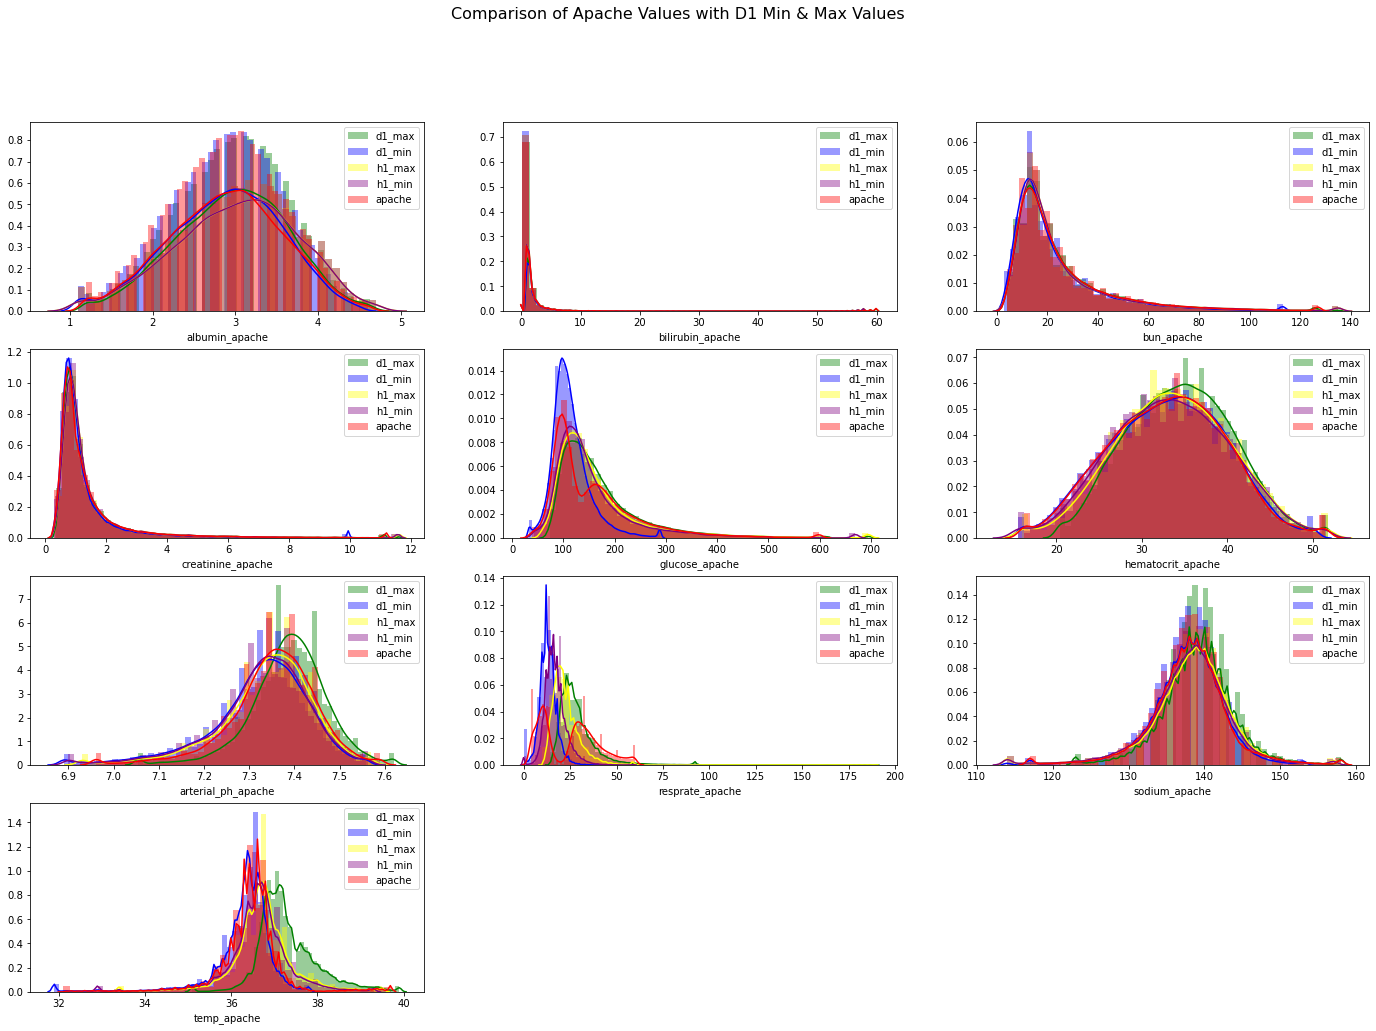

In [21]:
apache_cols = train_df.columns[train_df.columns.str.contains('apache')]
apache_cols = [c.split('_apache')[0] for c in apache_cols] 

vital_cols = train_df.columns[train_df.columns.str.startswith('d1') & train_df.columns.str.contains('_max')]
vital_cols = [(c.split('d1_')[1]).split('_max')[0] for c in vital_cols]

common_cols = [c for c in apache_cols if c in vital_cols]

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(24, 16))
fig.suptitle('Comparison of Apache Values with D1 Min & Max Values', fontsize=16)

k = 0
j = 0
for i, c in enumerate(common_cols):
    k = (k+1) if j == 2 else k
    j = i% 3
    
    sns.distplot(train_df[f"d1_{c}_max"], ax=ax[k, j], label = 'd1_max', color='green')
    sns.distplot(train_df[f"d1_{c}_min"], ax=ax[k, j], label = 'd1_min', color='blue')
    sns.distplot(train_df[f"h1_{c}_max"], ax=ax[k, j], label = 'h1_max', color='yellow')
    sns.distplot(train_df[f"h1_{c}_min"], ax=ax[k, j], label = 'h1_min', color='purple')
    sns.distplot(train_df[f"{c}_apache"], ax=ax[k, j], label = 'apache', color='red')
    ax[k, j].legend()

fig.delaxes(ax[3,1])
fig.delaxes(ax[3,2])
plt.show()

In [22]:
for c in ['albumin', 'hematocrit', 'temp', 'sodium']:
    # Fill empty d1_..._max column from available ..._apache column
    train_df[f"d1_{c}_min"] = np.where((train_df[f"d1_{c}_min"].isna() 
                                        & train_df[f"{c}_apache"].notna()), 
                                       train_df[f"{c}_apache"], 
                                       train_df[f"d1_{c}_min"])

    test_df[f"d1_{c}_min"] = np.where((test_df[f"d1_{c}_min"].isna() 
                                       & test_df[f"{c}_apache"].notna()), 
                                       test_df[f"{c}_apache"], 
                                       test_df[f"d1_{c}_min"])
    # Drop ..._apache column
    train_df.drop(f"{c}_apache", axis=1, inplace=True)
    test_df.drop(f"{c}_apache", axis=1, inplace=True)

for c in ['bilirubin', 'bun']:
    # Fill empty d1_..._max column from available ..._apache column
    train_df[f"d1_{c}_max"] = np.where((train_df[f"d1_{c}_max"].isna() 
                                        & train_df[f"{c}_apache"].notna()), 
                                       train_df[f"{c}_apache"], 
                                       train_df[f"d1_{c}_max"])

    test_df[f"d1_{c}_max"] = np.where((test_df[f"d1_{c}_max"].isna() 
                                       & test_df[f"{c}_apache"].notna()), 
                                       test_df[f"{c}_apache"], 
                                       test_df[f"d1_{c}_max"])
    # Drop ..._apache column
    train_df.drop(f"{c}_apache", axis=1, inplace=True)
    test_df.drop(f"{c}_apache", axis=1, inplace=True)

In [23]:
bimodal_apache = ['glucose_apache', 'heart_rate_apache', 'map_apache', 'resprate_apache', 'wbc_apache', 'creatinine_apache']

# Drop ..._apache column
train_df.drop(bimodal_apache, axis=1, inplace=True)
test_df.drop(bimodal_apache, axis=1, inplace=True)

The **oxigenation index or Horowitz index** is the ratio of partial pressure of oxygen in blood (PaO2) and the fraction of oxygen in the inhaled air (FiO2). Therefore, we can fill the missing values of `d1_pao2fio2ratio_max` with `pao2_apache`/`fio2_apache`.

In [24]:
train_df["d1_pao2fio2ratio_max"] = np.where((train_df["pao2_apache"].notna() 
                                             & train_df["fio2_apache"].notna()
                                             & train_df["d1_pao2fio2ratio_max"].isna() ), 
                                            train_df["pao2_apache"] / train_df["fio2_apache"], 
                                            train_df["d1_pao2fio2ratio_max"])

test_df["d1_pao2fio2ratio_max"] = np.where((test_df["pao2_apache"].notna() 
                                             & test_df["fio2_apache"].notna()
                                             & test_df["d1_pao2fio2ratio_max"].isna() ), 
                                            test_df["pao2_apache"] / test_df["fio2_apache"], 
                                            test_df["d1_pao2fio2ratio_max"])

As suggested by https://www.kaggle.com/siavrez/2020fatures/ and https://www.kaggle.com/kainsama/lgbm-wids2021-v0-1-1, we can group the vital signs by the APACHE diagnosis and patient profile.

In [25]:
# Edited from https://www.kaggle.com/siavrez/2020fatures/data

# Patient profile
train_df['age_bins'] = pd.cut(train_df.age, [0, 20, 30, 40, 50, 60, 70, 80, 120], labels=False)
test_df['age_bins'] = pd.cut(test_df.age, [0, 20, 30, 40, 50, 60, 70, 80, 120], labels=False)

train_df['bmi_bins'] = pd.cut(train_df.bmi, [0, 18.5, 25, 30, 75 ], labels=False)
test_df['bmi_bins'] = pd.cut(test_df.bmi, [0, 18.5, 25, 30, 75  ], labels=False)

profile_features = ['age_bins', 'ethnicity', 'gender', 'bmi_bins'] 
train_df['profile'] = train_df[profile_features].apply(lambda x: hash(tuple(x)), axis = 1)
test_df['profile'] = test_df[profile_features].apply(lambda x: hash(tuple(x)), axis = 1)

bin_cols = ['age_bins', 'bmi_bins']
train_df.drop(bin_cols, axis=1, inplace=True)
test_df.drop(bin_cols, axis=1, inplace=True)

cat_cols = ['ethnicity', 'icu_admit_source', 'icu_type']
train_df.drop(cat_cols, axis=1, inplace=True)
test_df.drop(cat_cols, axis=1, inplace=True)

print(f'Number of unique Profiles : {train_df["profile"].nunique()}')
print(f'Number of unique Profiles : {test_df["profile"].nunique()}')
print(f'Number of profiles only in test set : {len([c for c in test_df["profile"].unique() if c not in train_df["profile"].unique()])}')

Number of unique Profiles : 382
Number of unique Profiles : 321
Number of profiles only in test set : 0


In [26]:
vital_cols = list(apache_vital_cols) + list(lab_vital_cols)
vital_cols = [c for c in vital_cols if c in train_df.columns]

# Edited from https://www.kaggle.com/kainsama/lgbm-wids2021-v0-1-1
# Edited from https://www.kaggle.com/siavrez/2020fatures
groupers = ['apache_3j_diagnosis', 'profile']

for g in groupers:
    for v in tqdm(vital_cols):
        agg = train_df.groupby(g)[v].agg(['mean'])
        agg.columns = [f"{v}_{g}_mean"] 

        # Merge
        train_df = train_df.merge(agg, on=[g], how='left')
        test_df = test_df.merge(agg, on=[g], how='left')

        # Calculate difference
        train_df[f"{v}_{g}_diff"]  =  train_df[f"{v}_{g}_mean"] - train_df[v]
        test_df[f"{v}_{g}_diff"]  =  test_df[f"{v}_{g}_mean"] - test_df[v]

        train_df.drop([f"{v}_{g}_mean"], axis=1, inplace=True)
        test_df.drop([f"{v}_{g}_mean"], axis=1, inplace=True)

100%|██████████| 108/108 [03:00<00:00,  1.67s/it]


The vitals have a minimum and a maximum values from the first 24 hours. From the values we can create some additional features: **range, mean and signal to noise**. Additionally, we can counts the number of nans and whether d1 and h1 values are equals as suggested by https://www.kaggle.com/siavrez/2020fatures/.

In [ ]:
for v in tqdm(lab_vitals):
    v_cols = [x for x in test_df.columns if v in x]
    train_df[f"{v}_nans"] = train_df.loc[:, v_cols].isna().sum(axis=1)
    train_df[f"{v}_d1_h1_max_eq"] = (train_df[f"d1_{v}_max"]== train_df[f"h1_{v}_max"]).astype(np.int8)
    train_df[f"{v}_d1_h1_min_eq"] = (train_df[f"d1_{v}_min"]== train_df[f"h1_{v}_min"]).astype(np.int8)

    # Edited from https://www.kaggle.com/siavrez/2020fatures/data
    train_df[f'd1_{v}_range'] = train_df[f'd1_{v}_max'] - train_df[f'd1_{v}_min']
    train_df[f'd1_{v}_mean'] = (train_df[f'd1_{v}_max'] + train_df[f'd1_{v}_min']) / 2
    train_df[f'd1_{v}_s2n'] = (train_df[f'd1_{v}_mean'] / (train_df[f'd1_{v}_range']))
   
    train_df[f'h1_{v}_range'] = train_df[f'h1_{v}_max'] - train_df[f'h1_{v}_min']
    train_df[f'h1_{v}_mean'] = (train_df[f'h1_{v}_max'] + train_df[f'h1_{v}_min']) / 2
    train_df[f'h1_{v}_s2n'] = (train_df[f'h1_{v}_mean'] / (train_df[f'h1_{v}_range']))   
    
    # Edited from https://www.kaggle.com/siavrez/2020fatures/data
    test_df[f"{v}_nans"] = test_df.loc[:, v_cols].isna().sum(axis=1)
    test_df[f"{v}_d1_h1_max_eq"] = (test_df[f"d1_{v}_max"]== test_df[f"h1_{v}_max"]).astype(np.int8)
    test_df[f"{v}_d1_h1_min_eq"] = (test_df[f"d1_{v}_min"]== test_df[f"h1_{v}_min"]).astype(np.int8)

    test_df[f'd1_{v}_range'] = test_df[f'd1_{v}_max'] - test_df[f'd1_{v}_min']
    test_df[f'd1_{v}_mean'] = (test_df[f'd1_{v}_max'] + test_df[f'd1_{v}_min']) / 2
    test_df[f'd1_{v}_s2n'] = (test_df[f'd1_{v}_mean'] / test_df[f'd1_{v}_range'])
    
    test_df[f'h1_{v}_range'] = test_df[f'h1_{v}_max'] - test_df[f'h1_{v}_min']
    test_df[f'h1_{v}_mean'] = (test_df[f'h1_{v}_max'] + test_df[f'h1_{v}_min']) / 2
    test_df[f'h1_{v}_s2n'] = (test_df[f'h1_{v}_mean'] / (test_df[f'h1_{v}_range']))  

 96%|█████████▌| 25/26 [00:09<00:00,  2.21it/s]

## Blood Pressure

A patient's blood pressure level can be categorized according to the systolic and diastolic blood pressure.

In [ ]:
def get_blood_pressure_category(sysbp, diasbp):
    if ((sysbp < 90) & (diasbp < 60)):
        return -1 # Low blood pressure
    elif ((sysbp < 120) & (diasbp < 80)):
        return 0 # Normal
    elif ((sysbp < 140) & (diasbp < 90)):
        return 1 # Pre-Hypertension
    elif ((sysbp < 160) & (diasbp < 100)):
        return 2 # Stage 1 Hypertension
    else:
        return 3 # Stage 2 Hypertension
    
train_df['bp_cat'] = train_df[['d1_sysbp_mean', 'd1_diasbp_mean']].apply(lambda x: get_blood_pressure_category(x.d1_sysbp_mean, x.d1_diasbp_mean), axis=1)
test_df['bp_cat'] = test_df[['d1_sysbp_mean', 'd1_diasbp_mean']].apply(lambda x: get_blood_pressure_category(x.d1_sysbp_mean, x.d1_diasbp_mean), axis=1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

sns.scatterplot(y=train_df.d1_sysbp_mean, 
                x=train_df.d1_diasbp_mean, 
                hue=train_df.bp_cat, 
                palette=['steelblue', 'mediumseagreen', 'peachpuff', 'lightcoral', 'indianred'], 
                linewidth=0, 
                marker='.', 
                color='grey',
               ax=ax[0])
ax[0].set_xlim([20,130])
ax[0].set_ylim([60,200])
ax[0].set_xlabel('Diastolic Blood Pressure', fontsize=14)
ax[0].set_ylabel('Systolic Blood Pressure', fontsize=14)
ax[0].legend(['', 'Blood Pressure Category', 'low', 'normal', 'pre hypertension', 'stage 1 hypertension', 'stage 2 hypertension'])


# Prepare temporary dataframe for visualization
temp = (train_df.groupby(['bp_cat']).diabetes_mellitus.value_counts(normalize=True)*100).to_frame()
temp.columns = ['percentage']
temp.reset_index(inplace=True)
temp = temp.pivot(index='bp_cat', columns = 'diabetes_mellitus')['percentage']
temp.insert(0, '', 100 - temp[0])

# Plot
temp.plot.barh(stacked=True, color=['white', 'mediumseagreen', 'lightcoral'], edgecolor='none', legend=True, ax=ax[1])
ax[1].legend(['Diabetes Mellitus', 'No', 'Yes'], loc='upper right')
ax[1].axvline(100, linestyle='--', color='black', alpha=.5)
ax[1].set_zorder(-100)

ax[1].set_xlim(0, 200)
ax[1].set_xticklabels(['100', '75', '50','25', '0','25', '50', '75','100'])
ax[1].set_yticklabels(['Low', 'Normal', 'Pre Hypertension', 'Stage 1 Hypertension', 'Stage 2 Hypertension'])


ax[1].set_xlabel('Percentage [%]', fontsize=14)
ax[1].set_ylabel('', fontsize=14)

for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax[1].set_title("Percentage of Patients with Diabetes Mellitus\n According to Blood Pressure Levels", fontsize=16)
plt.tight_layout()
plt.show()


# Model
## Feature Selection

As suggested in https://www.kaggle.com/siavrez/2020fatures, we will select features based on null importances as described in https://www.kaggle.com/ogrellier/feature-selection-with-null-importances.

In [ ]:
features = [c for c in train_df.columns if (c not in  ['diabetes_mellitus', 'encounter_id', 'hospital_id'])]
target = ['diabetes_mellitus']

# Prepare training and test data
X, y = train_df[features], train_df[target]
    
display(X.head().style.set_caption("X"))
display(y.head().style.set_caption("y"))

X_test = test_df[features]

In [ ]:
model_params = {
    "objective": "binary",
    "metric":"auc",
    "seed": SEED,
    'num_iterations': 500, 
    "learning_rate": 0.05,
    "max_depth": 8,
    "num_leaves" : 32, 
    "is_unbalace" : True, 
    "min_data_in_leaf": 200,
    "lambda_l1" : 1,
    "lambda_l2": 0.1,
    "bagging_fraction" : 0.7,
    "feature_fraction" : 0.8, 
    "min_split_gain" : 0.5, 
    "subsample_for_bin" : 200,
    "n_jobs" : -1,
}

#Copied from https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

def get_feature_importances(X_train, y_train, params, shuffle, seed=None):

    # Shuffle target if required
    if shuffle:
        # Here you could as well use a binomial distribution
        y_train = y_train.sample(frac=1.0)
    
    # Fit LightGBM
    train_data = lgb.Dataset(X_train, y_train, free_raw_data=False, silent=True)
    
    # Fit the model
    clf = lgb.train(params=params, train_set=train_data)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(X_train.columns)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y_train, clf.predict(X_train))
    
    return imp_df

actual_imp_df = get_feature_importances(X, y, model_params, shuffle=False)

display(actual_imp_df.head())

null_imp_df = pd.DataFrame()
nb_runs = 32
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(X, y, model_params, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)

display(null_imp_df.head())

def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

    
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).head(50), ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).head(50), ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

scores_df['sum_score'] = scores_df.split_score+ scores_df.gain_score
drop_cols = scores_df[(scores_df.split_score<0) & (scores_df.gain_score <0) & (scores_df.sum_score < -5)].feature.values
print(drop_cols)

"""
drop_cols = ['apache_post_operative', 'intubated_apache', 'h1_bilirubin_min',
 'h1_hco3_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max',
 'h1_lactate_min' ,'h1_pao2fio2ratio_max' ,'aids', 'hepatic_failure',
 'leukemia', 'lymphoma', 'ethnicity_Native American',
 'ethnicity_Other/Unknown', 'icu_admit_source_Accident & Emergency',
 'icu_admit_source_Other Hospital' ,'icu_admit_source_Other ICU',
 'icu_type_CTICU', 'icu_type_Cardiac ICU',
 'h1_albumin_max_apache_3j_diagnosis_diff',
 'h1_albumin_min_apache_3j_diagnosis_diff',
 'h1_bilirubin_min_apache_3j_diagnosis_diff',
 'h1_lactate_max_apache_3j_diagnosis_diff',
 'h1_lactate_min_apache_3j_diagnosis_diff',
 'h1_arterial_pco2_max_apache_3j_diagnosis_diff',
 'h1_albumin_max_profile_diff', 'diasbp_nans', 'diasbp_d1_h1_max_eq',
 'diasbp_d1_h1_min_eq', 'heartrate_nans', 'mbp_nans' ,'mbp_d1_h1_min_eq',
 'resprate_nans', 'resprate_d1_h1_max_eq', 'resprate_d1_h1_min_eq',
 'spo2_nans', 'spo2_d1_h1_max_eq', 'sysbp_nans', 'temp_nans',
 'temp_d1_h1_max_eq', 'albumin_nans' ,'albumin_d1_h1_max_eq',
 'albumin_d1_h1_min_eq' ,'h1_albumin_range' ,'h1_albumin_mean',
 'h1_albumin_s2n', 'bilirubin_nans', 'bilirubin_d1_h1_max_eq',
 'bilirubin_d1_h1_min_eq', 'h1_bilirubin_range', 'h1_bilirubin_mean',
 'h1_bilirubin_s2n' ,'bun_nans', 'bun_d1_h1_max_eq', 'h1_bun_range',
 'h1_bun_s2n', 'calcium_nans' ,'h1_calcium_s2n', 'creatinine_nans',
 'creatinine_d1_h1_max_eq', 'creatinine_d1_h1_min_eq' ,'h1_creatinine_range',
 'h1_creatinine_s2n', 'glucose_nans', 'hco3_nans', 'hco3_d1_h1_max_eq',
 'h1_hco3_range' ,'h1_hco3_s2n', 'hemaglobin_nans', 'hemaglobin_d1_h1_max_eq',
 'hemaglobin_d1_h1_min_eq', 'h1_hemaglobin_range' ,'h1_hemaglobin_s2n',
 'hematocrit_nans', 'hematocrit_d1_h1_max_eq', 'hematocrit_d1_h1_min_eq',
 'h1_hematocrit_range', 'h1_hematocrit_s2n' ,'inr_nans' ,'inr_d1_h1_max_eq',
 'inr_d1_h1_min_eq' ,'h1_inr_range', 'h1_inr_mean', 'lactate_nans',
 'lactate_d1_h1_max_eq', 'lactate_d1_h1_min_eq', 'h1_lactate_range',
 'h1_lactate_mean' ,'h1_lactate_s2n', 'platelets_nans',
 'platelets_d1_h1_min_eq', 'h1_platelets_range', 'h1_platelets_s2n',
 'potassium_nans' ,'h1_potassium_s2n', 'sodium_nans', 'sodium_d1_h1_max_eq',
 'sodium_d1_h1_min_eq', 'wbc_nans' ,'wbc_d1_h1_min_eq' ,'h1_wbc_range',
 'h1_wbc_s2n', 'arterial_pco2_d1_h1_max_eq', 'arterial_pco2_d1_h1_min_eq',
 'h1_arterial_pco2_range' ,'h1_arterial_pco2_mean' ,'h1_arterial_pco2_s2n',
 'arterial_ph_nans' ,'arterial_ph_d1_h1_max_eq', 'arterial_ph_d1_h1_min_eq',
 'h1_arterial_ph_range' ,'h1_arterial_ph_s2n', 'arterial_po2_nans',
 'arterial_po2_d1_h1_max_eq' ,'h1_arterial_po2_range' ,'h1_arterial_po2_s2n',
 'pao2fio2ratio_nans' ,'pao2fio2ratio_d1_h1_max_eq',
 'h1_pao2fio2ratio_range', 'h1_pao2fio2ratio_mean' ,'h1_pao2fio2ratio_s2n']
"""
#

In [ ]:
features = [c for c in train_df.columns if (c not in  ['diabetes_mellitus', 'encounter_id', 'hospital_id']) & (c not in  drop_cols)]
target = ['diabetes_mellitus']

# Prepare training and test data
X, y = train_df[features], train_df[target]
    
display(X.head().style.set_caption("X"))
display(y.head().style.set_caption("y"))

X_test = test_df[features]

## Hyper Parameter Tuning

* `objective`: `binary` because we have binary classification problem
* `metric`: `auc` as the competition metric
* `seed`: can be set to anything as long as it is set for reproducible results
* It is recommended to use smaller `learning_rate` with larger `num_iterations`. Also, you should use `early_stopping_rounds` if you go for higher `num_iterations` to stop your training when it is not learning anything useful. `learning_rate` is set to 0.1 during hyper parameter tuning and decreased afterwards
* `num_leaves` and `max_depth`: Control the complexity of the tree. `num_leaves` < 2^`max_depth` to avoid overfitting. Default 31,-1
* `sample_pos_weight` = number of negative samples / number of positive samples or `is_unbalace`

In [ ]:
"""
# Hyper Parameter Tuning
from sklearn.model_selection import GridSearchCV

# Create parameters to search
gridParams = {"num_leaves" : [16, 32, 64, 128],
             }

mdl = lgb.LGBMClassifier(objective = 'binary',
                         metric = "auc",
                         seed = SEED,
                         num_iterations = 300,
                         #min_data_in_leaf=50,
                         learning_rate =  0.1,
                         lambda_l1 = 0,
                         lambda_l2 = 0.1,
                         bagging_fraction = 0.7,
                         feature_fraction = 0.9, 
                        min_data_in_leaf = 200,)

# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=4,
                    cv=5,
                    n_jobs=-1)
# Run the grid
grid.fit(X, y)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)
"""

## Pseudo Labelling 
We will run the model once to use predictions with a high confidence from the testing set as additional training data.

In [ ]:
N_SPLITS = 5

model_params = {
    "objective": "binary",
    "metric":"auc",
    "seed": SEED,
    'num_iterations': 500,
    "learning_rate": 0.05,
    "max_depth": 8,
    "num_leaves" : 32, 
    "is_unbalace" : True, 
    "min_data_in_leaf": 200,
    "lambda_l1" : 1,
    "lambda_l2": 0.1,
    "bagging_fraction" : 0.7,
    "feature_fraction" : 0.8, 
    "min_split_gain" : 0.5, 
    "subsample_for_bin" : 200,
    "n_jobs" : -1,
}

# Initialize variables
y_oof_pred = np.zeros(len(X))
y_test_pred = np.zeros(len(X_test))

kf = GroupKFold(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y, train_df.hospital_id)):
    print(f"Fold {fold + 1}:")

    # Prepare training and validation data
    X_train = X.iloc[train_idx].reset_index(drop=True)
    X_val = X.iloc[val_idx].reset_index(drop=True)

    y_train = y.iloc[train_idx].reset_index(drop=True)
    y_val = y.iloc[val_idx].reset_index(drop=True)  

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    # Define model
    model = lgb.train(params=model_params,
                      train_set=train_data,
                      valid_sets=[train_data, val_data],
                      verbose_eval=50,
                     )

    # Calculate evaluation metric
    y_val_pred = model.predict(X_val)
    print(f"Original ROC AUC: {roc_auc_score(y_val, y_val_pred)}")

    # Make predictions
    y_oof_pred[val_idx] = y_val_pred
    y_test_pred += model.predict(X_test)

# Calculate evaluation metric for out of fold validation set
y_test_pred = y_test_pred / N_SPLITS

In [ ]:
def get_predictions(y_pred):
    return (y_pred > 0.5).astype(int)

print(f"Mean ROC AUC: {roc_auc_score(y, y_oof_pred)} \n")

y_oof_pred = get_predictions(y_oof_pred) 

print(f"F1 Macro Score: {f1_score(y, y_oof_pred, average='macro')}\n")
precision, recall, _, _ = precision_recall_fscore_support(y, y_oof_pred, average=None)
print(f"Precision: {precision} \nRecall: {recall}\n")

sns.heatmap(confusion_matrix(y, y_oof_pred), cmap='Blues', annot=True, fmt=".5g")
plt.show()

In [ ]:
train_df_pseudo = test_df[(pd.Series(y_test_pred) > 0.8) | (test_df.APACHE_diabetic_ketoacidosis == 1)].copy()
train_df_pseudo['diabetes_mellitus'] = 1
print(f"Additional {len(train_df_pseudo)} data points for pseudo labelling.")
train_df_mod = train_df.append(train_df_pseudo)

# Shuffle dataframe
train_df_mod = train_df_mod.sample(frac=1).reset_index(drop=True)

## Training and Validation

In [ ]:
# Prepare training and test data
X, y = train_df_mod[features], train_df_mod[target]

display(X.head().style.set_caption("X"))
display(y.head().style.set_caption("y"))

X_test = test_df[features]

In [ ]:
N_SPLITS = 5

model_params = {
    "objective": "binary",
    "metric":"auc",
    "seed": SEED,
    'num_iterations': 5000,
    "early_stopping_rounds": 250,
    "learning_rate": 0.01,
    "max_depth": 8,
    "num_leaves" : 32, 
    "is_unbalace" : True, 
    "min_data_in_leaf": 200,
    "lambda_l1" : 1,
    "lambda_l2": 0.1,
    "bagging_fraction" : 0.7,
    "feature_fraction" : 0.8, 
    "min_split_gain" : 0.5, 
    "subsample_for_bin" : 200,
    "n_jobs" : -1,
}

### Model 2: CV2 with StratifiedKFold

In [ ]:
# Initialize variables
y_oof_pred = np.zeros(len(X))
y_test_pred = np.zeros(len(X_test))

kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}:")

    # Prepare training and validation data
    X_train = X.iloc[train_idx].reset_index(drop=True)
    X_val = X.iloc[val_idx].reset_index(drop=True)

    y_train = y.iloc[train_idx].reset_index(drop=True)
    y_val = y.iloc[val_idx].reset_index(drop=True)  

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    # Define model
    model = lgb.train(params=model_params,
                      train_set=train_data,
                      valid_sets=[train_data, val_data],
                      verbose_eval=50,
                     )

    # Calculate evaluation metric
    y_val_pred = model.predict(X_val)
    print(f"Original ROC AUC: {roc_auc_score(y_val, y_val_pred)}")

    # Make predictions
    y_oof_pred[val_idx] = y_val_pred
    y_test_pred += model.predict(X_test)

# Calculate evaluation metric for out of fold validation set
y_test_pred_stratified = y_test_pred / N_SPLITS

In [ ]:
print(f"Mean ROC AUC: {roc_auc_score(y, y_oof_pred)} \n")

y_oof_pred = get_predictions(y_oof_pred) 

print(f"F1 Macro Score: {f1_score(y, y_oof_pred, average='macro')}\n")
precision, recall, _, _ = precision_recall_fscore_support(y, y_oof_pred, average=None)
print(f"Precision: {precision} \nRecall: {recall}\n")

sns.heatmap(confusion_matrix(y, y_oof_pred), cmap='Blues', annot=True, fmt=".5g")
plt.show()

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type="gain"),X.columns)), columns=['Value','Feature'])

fig, ax = plt.subplots(1,2, figsize=(16, 12))
feature_imp.sort_values('Value', ascending=True).tail(30).set_index('Feature').plot.barh(ax=ax[0])
ax[0].set_title('Top 20 Most Important Features')
feature_imp.sort_values('Value', ascending=True).head(30).set_index('Feature').plot.barh(ax=ax[1])
ax[1].set_title('Bottom 20 Least Important Features')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
(train_df.diabetes_mellitus.value_counts(normalize=True)*100).plot(kind='bar', color=['mediumseagreen', 'lightcoral'], ax=ax[0])
ax[0].set_title('Ground Truth')

display((pd.Series(get_predictions(y_test_pred_stratified)).value_counts(normalize=True)*100))
(pd.Series(get_predictions(y_test_pred_stratified)).value_counts(normalize=True)*100).plot(kind='bar', color=['mediumseagreen', 'lightcoral'], ax=ax[1])
ax[1].set_title('Predicted')
for i in range(2):
    ax[i].set_ylim([0, 100])
    ax[i].set_ylabel('Percentage of Patients[%]', fontsize=14)
    ax[i].set_xticklabels(['No Diabetes', 'Diabetes'], fontsize=14, rotation=0)
plt.show()

### Model 2: CV2 with GroupKFold

In [ ]:
# Initialize variables
y_oof_pred = np.zeros(len(X))
y_test_pred = np.zeros(len(X_test))

kf = GroupKFold(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y, train_df_mod.hospital_id)):
    print(f"Fold {fold + 1}:")

    # Prepare training and validation data
    X_train = X.iloc[train_idx].reset_index(drop=True)
    X_val = X.iloc[val_idx].reset_index(drop=True)

    y_train = y.iloc[train_idx].reset_index(drop=True)
    y_val = y.iloc[val_idx].reset_index(drop=True)  

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    # Define model
    model = lgb.train(params=model_params,
                      train_set=train_data,
                      valid_sets=[train_data, val_data],
                      verbose_eval=50,
                     )

    # Calculate evaluation metric
    y_val_pred = model.predict(X_val)
    print(f"Original ROC AUC: {roc_auc_score(y_val, y_val_pred)}")

    # Make predictions
    y_oof_pred[val_idx] = y_val_pred
    y_test_pred += model.predict(X_test)

# Calculate evaluation metric for out of fold validation set
y_test_pred_grouped = y_test_pred / N_SPLITS

In [ ]:
print(f"Mean ROC AUC: {roc_auc_score(y, y_oof_pred)} \n")

y_oof_pred = get_predictions(y_oof_pred) 

print(f"F1 Macro Score: {f1_score(y, y_oof_pred, average='macro')}\n")
precision, recall, _, _ = precision_recall_fscore_support(y, y_oof_pred, average=None)
print(f"Precision: {precision} \nRecall: {recall}\n")

sns.heatmap(confusion_matrix(y, y_oof_pred), cmap='Blues', annot=True, fmt=".5g")
plt.show()

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type="gain"),X.columns)), columns=['Value','Feature'])

fig, ax = plt.subplots(1,2, figsize=(16, 12))
feature_imp.sort_values('Value', ascending=True).tail(30).set_index('Feature').plot.barh(ax=ax[0])
ax[0].set_title('Top 20 Most Important Features')
feature_imp.sort_values('Value', ascending=True).head(30).set_index('Feature').plot.barh(ax=ax[1])
ax[1].set_title('Bottom 20 Least Important Features')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
(train_df.diabetes_mellitus.value_counts(normalize=True)*100).plot(kind='bar', color=['mediumseagreen', 'lightcoral'], ax=ax[0])
ax[0].set_title('Ground Truth')

display((pd.Series(get_predictions(y_test_pred_grouped)).value_counts(normalize=True)*100))
(pd.Series(get_predictions(y_test_pred_grouped)).value_counts(normalize=True)*100).plot(kind='bar', color=['mediumseagreen', 'lightcoral'], ax=ax[1])
ax[1].set_title('Predicted')
for i in range(2):
    ax[i].set_ylim([0, 100])
    ax[i].set_ylabel('Percentage of Patients[%]', fontsize=14)
    ax[i].set_xticklabels(['No Diabetes', 'Diabetes'], fontsize=14, rotation=0)
plt.show()

## Ensemble

In [ ]:
y_test_pred = 0.6 * y_test_pred_stratified + 0.4 * y_test_pred_grouped

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
(train_df.diabetes_mellitus.value_counts(normalize=True)*100).plot(kind='bar', color=['mediumseagreen', 'lightcoral'], ax=ax[0])
ax[0].set_title('Ground Truth')

display((pd.Series(get_predictions(y_test_pred)).value_counts(normalize=True)*100))
(pd.Series(get_predictions(y_test_pred)).value_counts(normalize=True)*100).plot(kind='bar', color=['mediumseagreen', 'lightcoral'], ax=ax[1])
ax[1].set_title('Predicted')
for i in range(2):
    ax[i].set_ylim([0, 100])
    ax[i].set_ylabel('Percentage of Patients[%]', fontsize=14)
    ax[i].set_xticklabels(['No Diabetes', 'Diabetes'], fontsize=14, rotation=0)
plt.show()

# Submission

In [ ]:
submission = test_df[["encounter_id"]].copy()
submission['diabetes_mellitus'] = y_test_pred
submission.to_csv("submission.csv",index=False)
submission.head()

# References

## Links and Papers
[1] American Diabetes Association. (2019). 2. Classification and diagnosis of diabetes: standards of medical care in diabetes—2019. Diabetes care, 42(Supplement 1), S13-S28.

[2] World Health Organization (2020): Diabetes. https://www.who.int/news-room/fact-sheets/detail/diabetes 

[3] Nnamoko, N., & Korkontzelos, I. (2020). Efficient treatment of outliers and class imbalance for diabetes prediction. Artificial Intelligence in Medicine, 104, 101815.

[4] Sirivole, M. R., & Eturi, S. A. (2017). A study on blood urea and serum creatinine in diabetes mellitus from Sangareddy District, Telangana, India. Intern J Med Health Res, 3, 132-6.

[5] https://pubmed.ncbi.nlm.nih.gov/26972930/


## Most Valuable Kernels
https://www.kaggle.com/siavrez/2020fatures 

https://www.kaggle.com/kainsama/single-lgbm-v0-1-0

https://www.kaggle.com/kainsama/lgbm-wids2021-v0-1-1

https://www.kaggle.com/danofer/wids-2020-competitive-1st-place-component

https://www.kaggle.com/jayjay75/3rd-place-nn-wids2020?scriptVersionId=29209297

https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

## Most Valuable Dataset
https://www.kaggle.com/danofer/apache-iiij-icu-diagnosis-codes?select=icu-apache-codes-ANZICS.csv
